In [24]:
pip install transformers torch numpy gudhi -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [25]:
text = ["קלעזמער איז אַ טראַדיציאָנעלע ייִדיש מוזיק פון מיטל אייראָפע און רוסלאַנד, וואָס האָט זיך אויסגעוויקלט איבער די יאָרהונדערטן. דאָס נשמה קלאַנג איז קענטשענדיק פֿאַר זייַן הערציקע ניגונים און קענענדיקע ריטמען. זייַנע מוזיק האָט געווינען די באַגלייטונג פֿאַר אַלע לעבענס איבענטן, פֿון די הייליקע יאָמער צו די גלעזלעך פון שנאַפּס."]

In [26]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel  # Corrected import here

def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')
    model = AutoModel.from_pretrained("xlm-roberta-large")  # Corrected line here

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 106, 64])
tensor([[[-0.0560, -0.0188, -0.0196,  ..., -0.0190,  0.0121, -0.0159],
         [-0.0425, -0.0106, -0.0669,  ...,  0.0314,  0.0331,  0.0430],
         [ 0.0406,  0.0382, -0.0397,  ...,  0.0505, -0.0336,  0.0409],
         ...,
         [-0.3613,  0.0620, -0.2611,  ..., -0.1623,  0.2001,  0.2185],
         [-0.0128,  0.0160, -0.0340,  ...,  0.0264, -0.0071,  0.0340],
         [-0.0916,  0.0244,  0.0094,  ...,  0.0407,  0.0077, -0.0078]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:


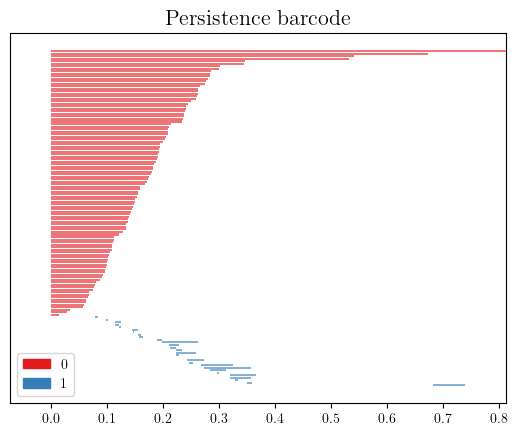

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [28]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=0.1):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: <s>, ▁אַ, ▁טר, אַד, אָנע, ▁פון, ▁און, ▁האָט, ▁זיך, ▁אויסגע, ▁און, ▁, ▁האָט, ייט, ב, ▁פֿון, ▁, ▁פון
Cluster 1: י, ניג
Cluster 2: ווי, ייַ
Cluster 3: ▁די, ▁די, ▁די
Cluster 4: ▁פֿאַר, ▁פֿאַר


Tokens of the sub-collection: ['▁באַ', 'גל', 'ייט', 'ונג', '▁פֿאַר', '▁אַלע', '▁לע', 'ב', 'ענס', '▁אי', 'בע', 'נטן']
Distance matrix: (12, 12)
Distance matrix: [[0.         0.37161135 0.40049196 0.40450526 0.4708538  0.4175652
  0.38166877 0.32174474 0.41124904 0.53055418 1.12058507 0.55221223]
 [0.37161135 0.         0.6938754  0.32637198 0.63282079 0.18669558
  0.13967249 0.33396939 0.36102485 0.60058658 1.08988954 0.52352948]
 [0.40049196 0.6938754  0.         0.74806974 0.39708315 0.7150947
  0.69362376 0.60449185 0.76063321 0.51543632 1.45780351 0.8943614 ]
 [0.40450526 0.32637198 0.74806974 0.         0.81382199 0.39175682
  0.34178542 0.42787206 0.09941246 0.8058495  0.88055072 0.25175595]
 [0.4708538  0.63282079 0.39708315 0.81382199 0.         0.62758634
  0.61586064 0.53402314 0.82731546 0.28330035 1.50952386 0.98273766]
 [0.4175652  0.18669558 0.7150947  0.39175682 0.62758634 0.
  0.17645315 0.40119187 0.42342027 0.60645063 1.12772447 0.57600515]
 [0.38166877 0.13967249 0.69

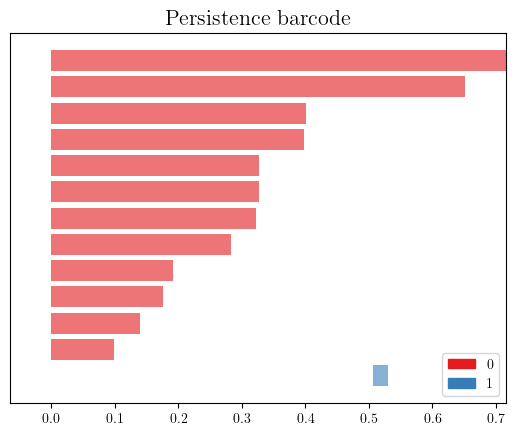

[(1, (0.5069878907930111, 0.5305541811976522)),
 (0, (0.0, inf)),
 (0, (0.0, 0.6508132954875305)),
 (0, (0.0, 0.4004919601688668)),
 (0, (0.0, 0.39708315357923757)),
 (0, (0.0, 0.32774184783240434)),
 (0, (0.0, 0.3263719846570727)),
 (0, (0.0, 0.3217447390530458)),
 (0, (0.0, 0.2833003482936052)),
 (0, (0.0, 0.19124176849837848)),
 (0, (0.0, 0.17645315363759018)),
 (0, (0.0, 0.13967248766522408)),
 (0, (0.0, 0.09941245876735676))]

In [29]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "באַגלייטונג פֿאַר אַלע לעבענס איבענטן")

In [30]:
text_2 = ["ייִדיש ליטעראַטור האָט אַ רייכע געשיכטע, פֿונעם מיטלאַלטער דורך די מאָדערנע צייטן. דער נשמה קלאַנג איז געפילט אין די ווערק פון מנהעם מענדל מאַניס, שאָלום עליכם, און י. ל. פּערעץ. זייַנע ווערטער האָבן געווינען די באַגלייטונג פֿאַר אַלע לעבענס איבענטן, פֿון די עמעסע מאַגילות צו די מאָדערנע ראָמאַנטישע נאָוועלן."]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokens of the sub-collection: ['▁באַ', 'גל', 'ייט', 'ונג', '▁פֿאַר', '▁אַלע', '▁לע', 'ב', 'ענס', '▁אי', 'בע', 'נטן']
Distance matrix: (12, 12)
Distance matrix: [[0.         0.40629703 0.51561242 0.465859   0.42060899 0.43322735
  0.44470979 0.39483073 0.51549594 0.77274005 1.07117834 0.65620187]
 [0.40629703 0.         0.85997423 0.22058418 0.66585823 0.21496059
  0.21717268 0.34509868 0.31875135 0.89909072 0.92594415 0.50599018]
 [0.51561242 0.85997423 0.         0.92196356 0.39806803 0.82934535
  0.83058528 0.780846   0.99006656 0.70429711 1.54685406 1.13133846]
 [0.465859   0.22058418 0.92196356 0.         0.79914046 0.38594271
  0.39588199 0.45527507 0.15419329 1.054901   0.80070016 0.34034577]
 [0.42060899 0.66585823 0.39806803 0.79914046 0.         0.60347265
  0.57431803 0.52813229 0.87099987 0.43648918 1.42935522 1.03413125]
 [0.43322735 0.21496059 0.82934535 0.38594271 0.60347265 0.
  0.1634562  0.35152789 0.46247246 0.80725271 1.02794136 0.63772869]
 [0.44470979 0.21717268 0.

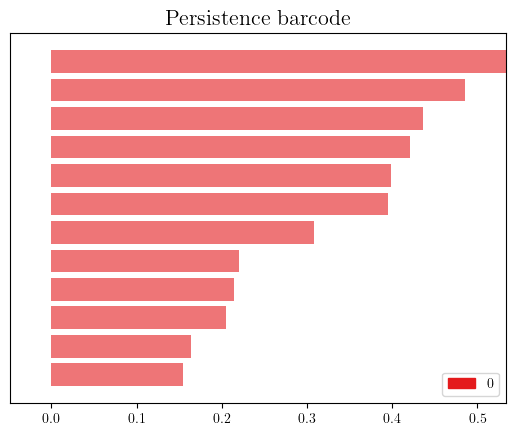

[(0, (0.0, inf)),
 (0, (0.0, 0.48508637383507236)),
 (0, (0.0, 0.43648917934305415)),
 (0, (0.0, 0.420608985461366)),
 (0, (0.0, 0.3980680313725759)),
 (0, (0.0, 0.39483073061390683)),
 (0, (0.0, 0.3085895475345927)),
 (0, (0.0, 0.22058417607350092)),
 (0, (0.0, 0.21496059188091451)),
 (0, (0.0, 0.2048583429565206)),
 (0, (0.0, 0.16345620401194352)),
 (0, (0.0, 0.15419328679652944))]

In [31]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "באַגלייטונג פֿאַר אַלע לעבענס איבענטן")

Tokens of the sub-collection: ['▁באַ', 'גל', 'ייט', 'ונג', '▁פֿאַר', '▁אַלע', '▁לע', 'ב', 'ענס', '▁אי', 'בע', 'נטן']
Distance matrix: (12, 12)
Distance matrix: [[0.         0.37161135 0.40049196 0.40450526 0.4708538  0.4175652
  0.38166877 0.32174474 0.41124904 0.53055418 1.12058507 0.55221223]
 [0.37161135 0.         0.6938754  0.32637198 0.63282079 0.18669558
  0.13967249 0.33396939 0.36102485 0.60058658 1.08988954 0.52352948]
 [0.40049196 0.6938754  0.         0.74806974 0.39708315 0.7150947
  0.69362376 0.60449185 0.76063321 0.51543632 1.45780351 0.8943614 ]
 [0.40450526 0.32637198 0.74806974 0.         0.81382199 0.39175682
  0.34178542 0.42787206 0.09941246 0.8058495  0.88055072 0.25175595]
 [0.4708538  0.63282079 0.39708315 0.81382199 0.         0.62758634
  0.61586064 0.53402314 0.82731546 0.28330035 1.50952386 0.98273766]
 [0.4175652  0.18669558 0.7150947  0.39175682 0.62758634 0.
  0.17645315 0.40119187 0.42342027 0.60645063 1.12772447 0.57600515]
 [0.38166877 0.13967249 0.69

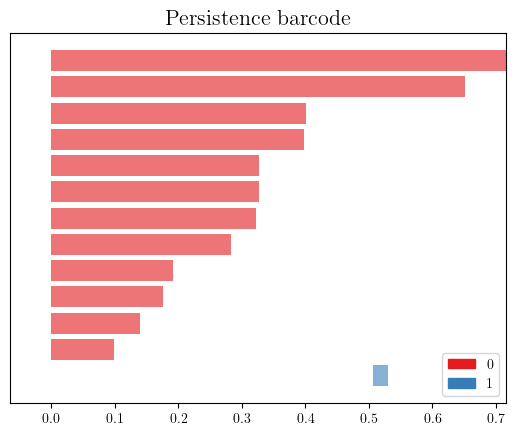

Tokens of the sub-collection: ['▁באַ', 'גל', 'ייט', 'ונג', '▁פֿאַר', '▁אַלע', '▁לע', 'ב', 'ענס', '▁אי', 'בע', 'נטן']
Distance matrix: (12, 12)
Distance matrix: [[0.         0.40629703 0.51561242 0.465859   0.42060899 0.43322735
  0.44470979 0.39483073 0.51549594 0.77274005 1.07117834 0.65620187]
 [0.40629703 0.         0.85997423 0.22058418 0.66585823 0.21496059
  0.21717268 0.34509868 0.31875135 0.89909072 0.92594415 0.50599018]
 [0.51561242 0.85997423 0.         0.92196356 0.39806803 0.82934535
  0.83058528 0.780846   0.99006656 0.70429711 1.54685406 1.13133846]
 [0.465859   0.22058418 0.92196356 0.         0.79914046 0.38594271
  0.39588199 0.45527507 0.15419329 1.054901   0.80070016 0.34034577]
 [0.42060899 0.66585823 0.39806803 0.79914046 0.         0.60347265
  0.57431803 0.52813229 0.87099987 0.43648918 1.42935522 1.03413125]
 [0.43322735 0.21496059 0.82934535 0.38594271 0.60347265 0.
  0.1634562  0.35152789 0.46247246 0.80725271 1.02794136 0.63772869]
 [0.44470979 0.21717268 0.

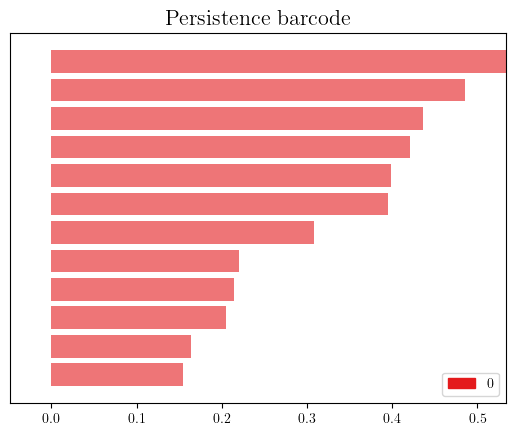

Bottleneck distance: 0.16572692165245817
Wasserstein distance: = 0.59


In [32]:
# from gudhi.wasserstein import wasserstein_distance 
# Could also be: 
from gudhi.hera import wasserstein_distance
import numpy as np

# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "באַגלייטונג פֿאַר אַלע לעבענס איבענטן")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "באַגלייטונג פֿאַר אַלע לעבענס איבענטן")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

In [33]:
text_3 = ["דער ייִדישער טעאַטער האָט אַ רייכע געשיכטע, פון די ערשטע וואַנדערנדיקע טרופּעס אויף די גאַסן פֿון מיטל אייראָפע, ביז צו די בראָדוויי שאָוז פון ניו יאָרק. זייַנע פֿאַרבינדונג פֿאַר אַ חלום האָט געווינען די לייטמאָטיװ פֿאַר פֿילע ייִדישע שטיקען, מיט די וויטגעהענדיקע קאַמעדיען און דראַמען וואָס האָבן געווינען די הערצן פֿון די פּובליקום."]

text_4 = ["פֿאַמיליע געטראַפֿענישן זענען אַ וויכטיקער טייל פון טראַדיציאָנעלע ייִדישע קולטור. די פֿאַרבינדונג פֿאַר אַ חלום איז אַ געמיינזאַמע אויסדרוק, וואָס באַזייכנט די וויכטיקייט פון שאַרען די הערצן פֿון די פּובליקום, אַזוי ווי די שבת מאַלזעטן אָדער די יאָמער פֿאַרברענגען."]

In [34]:
context_3 = [compute_output(t, layer, head) for t in text_3]

context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a

Tokens of the sub-collection: ['▁פֿאַר', 'בי', 'נד', 'ונג', '▁פֿאַר', '▁אַ', '▁חלו', 'ם']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.47107309 0.55787896 0.40451344 0.96032841 0.32427965
  0.41656233 0.33403235]
 [0.47107309 0.         0.50962817 0.34055833 1.19027359 0.26627615
  0.15740142 0.2509993 ]
 [0.55787896 0.50962817 0.         0.31967374 0.77844389 0.43194048
  0.56659091 0.50251536]
 [0.40451344 0.34055833 0.31967374 0.         0.95555343 0.35363873
  0.35306542 0.26105296]
 [0.96032841 1.19027359 0.77844389 0.95555343 0.         0.99962074
  1.2025106  1.1264676 ]
 [0.32427965 0.26627615 0.43194048 0.35363873 0.99962074 0.
  0.27412592 0.31215639]
 [0.41656233 0.15740142 0.56659091 0.35306542 1.2025106  0.27412592
  0.         0.22254782]
 [0.33403235 0.2509993  0.50251536 0.26105296 1.1264676  0.31215639
  0.22254782 0.        ]]


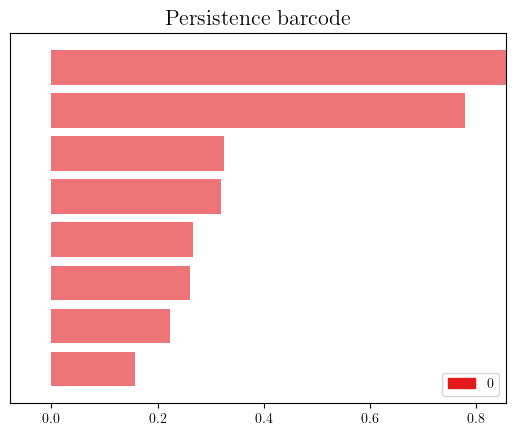

Tokens of the sub-collection: ['▁פֿאַר', 'בי', 'נד', 'ונג', '▁פֿאַר', '▁אַ', '▁חלו', 'ם']
Distance matrix: (8, 8)
Distance matrix: [[0.         0.69367674 0.42432072 0.71172268 0.54333963 0.47369443
  0.4959003  0.72959354]
 [0.69367674 0.         0.44185505 0.36203407 1.17922076 0.26207699
  0.27523833 0.31465543]
 [0.42432072 0.44185505 0.         0.42990599 0.85181954 0.3584632
  0.40571109 0.4906027 ]
 [0.71172268 0.36203407 0.42990599 0.         1.11471109 0.45528619
  0.44930591 0.19196426]
 [0.54333963 1.17922076 0.85181954 1.11471109 0.         0.98410969
  1.00619312 1.17670825]
 [0.47369443 0.26207699 0.3584632  0.45528619 0.98410969 0.
  0.09326505 0.4169314 ]
 [0.4959003  0.27523833 0.40571109 0.44930591 1.00619312 0.09326505
  0.         0.39413659]
 [0.72959354 0.31465543 0.4906027  0.19196426 1.17670825 0.4169314
  0.39413659 0.        ]]


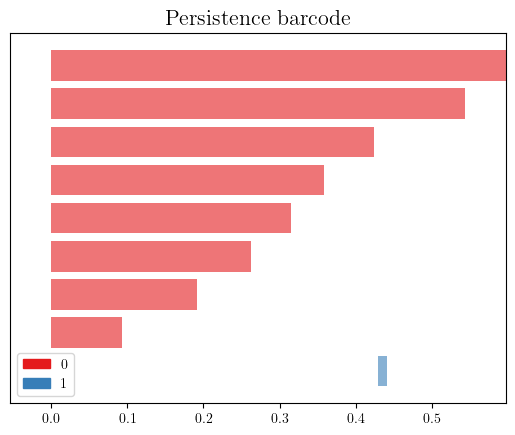

Bottleneck distance: 0.23510426163924902
Wasserstein distance: = 0.53


In [35]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0], "פֿאַרבינדונג פֿאַר אַ חלום")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0], "פֿאַרבינדונג פֿאַר אַ חלום")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")

Tokens of the sub-collection: ['▁די', '▁הער', 'צן', '▁פֿון', '▁די', '▁', 'פּו', 'בליק', 'ום']
Distance matrix: (9, 9)
Distance matrix: [[0.         0.8083221  0.46406217 1.69564153 0.63176781 0.43953206
  0.54332666 0.61415692 0.4229852 ]
 [0.8083221  0.         0.55999465 1.0027532  1.13923408 0.94457425
  1.06073061 1.13506239 0.74948535]
 [0.46406217 0.55999465 0.         1.41243447 0.83120964 0.58977949
  0.73491282 0.82287476 0.43335427]
 [1.69564153 1.0027532  1.41243447 0.         2.09892841 1.90222592
  2.01487493 2.08903122 1.62908593]
 [0.63176781 1.13923408 0.83120964 2.09892841 0.         0.26132392
  0.12048438 0.08426419 0.56430012]
 [0.43953206 0.94457425 0.58977949 1.90222592 0.26132392 0.
  0.16615316 0.25707026 0.38562807]
 [0.54332666 1.06073061 0.73491282 2.01487493 0.12048438 0.16615316
  0.         0.10402212 0.46927943]
 [0.61415692 1.13506239 0.82287476 2.08903122 0.08426419 0.25707026
  0.10402212 0.         0.54438815]
 [0.4229852  0.74948535 0.43335427 1.6290

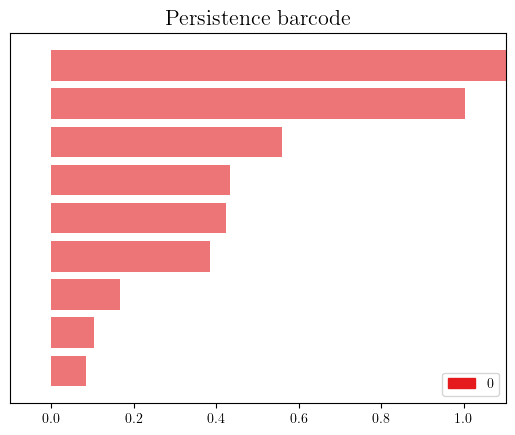

Tokens of the sub-collection: ['▁די', '▁הער', 'צן', '▁פֿון', '▁די', '▁', 'פּו', 'בליק', 'ום']
Distance matrix: (9, 9)
Distance matrix: [[0.         1.31523913 0.39794027 2.11001492 0.66884882 0.46025347
  0.54787076 0.65492294 0.35152769]
 [1.31523913 0.         1.11863725 1.06471106 1.59605173 1.23245933
  1.53716665 1.59814708 1.17297038]
 [0.39794027 1.11863725 0.         1.88259211 0.82559301 0.50281459
  0.70623619 0.81627719 0.41770209]
 [2.11001492 1.06471106 1.88259211 0.         2.51516816 2.15270154
  2.44449073 2.52127944 2.01969265]
 [0.66884882 1.59605173 0.82559301 2.51516816 0.         0.39688509
  0.16379483 0.11120523 0.58414124]
 [0.46025347 1.23245933 0.50281459 2.15270154 0.39688509 0.
  0.31643234 0.39630135 0.29159519]
 [0.54787076 1.53716665 0.70623619 2.44449073 0.16379483 0.31643234
  0.         0.13568301 0.48743629]
 [0.65492294 1.59814708 0.81627719 2.52127944 0.11120523 0.39630135
  0.13568301 0.         0.57478441]
 [0.35152769 1.17297038 0.41770209 2.0196

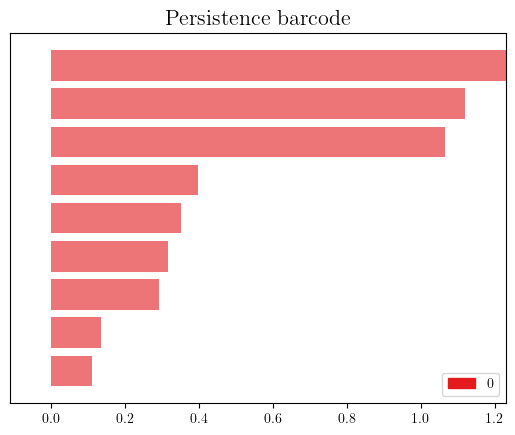

Bottleneck distance: 0.5047164093310836
Wasserstein distance: = 0.98


In [36]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context_3[0], text_3[0],  "די הערצן פֿון די פּובליקום")
persistent_homology_2 = compute_phrase_distances_and_homology(context_4[0], text_4[0],  "די הערצן פֿון די פּובליקום")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")